In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"


%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_pt', 'wl_eta', 'wl_phi']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']


Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  100000 

In [2]:
import scale_variables
import shape_timesteps

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'carteta', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'meanmax', 'm':'boxcox', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(Y_keys, Y_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 1.7053025658242404e-13


In [3]:
# Create X and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 

trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

# Save some memory 
del totalX_jets
del totalX_other 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(80000, 6, 5) (80000, 6) (80000, 9)
(20000, 6, 5) (20000, 6) (20000, 9)


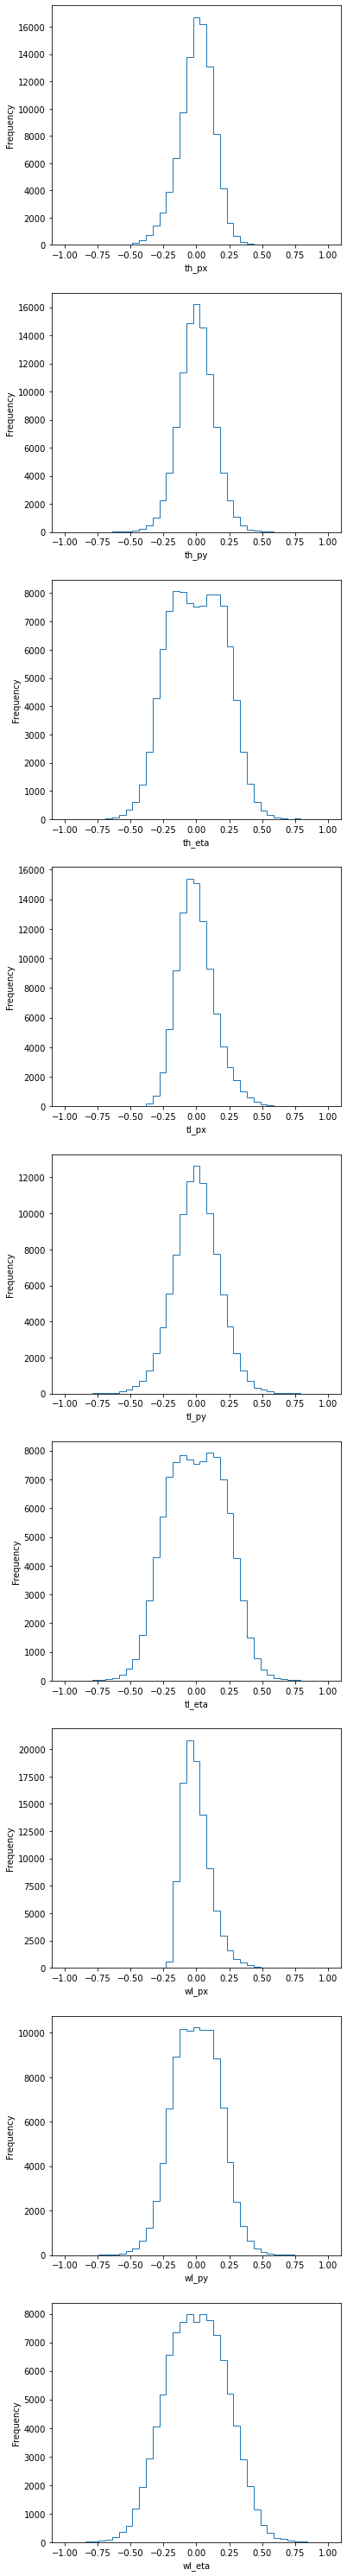

In [4]:
# Histograms of total  Y variables 
show = True

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-0.1, 0.1, 40)
pt_bins = np.linspace(-0.3, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [5]:
# Histograms of X variables (without the mask)
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [6]:
# Build model

def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    LSTM11 = LSTM(64, return_sequences=True)(Mask)
    LSTM12 = LSTM(64, return_sequences=True)(LSTM11)
    
    flat_jets = Flatten()(LSTM12)
    
    other_input = Input(shape=(trainX_other.shape[1]))
    Dense21 = Dense(64, activation='relu')(other_input)
    flat_other = Flatten()(Dense21)
    
    concat = concatenate([flat_other, flat_jets])
    dense1 = Dense(256, activation='relu')(concat)
    dense2 = Dense(128, activation='relu')(dense1)
    output = Dense(len(Y_names), activation='linear')(dense2)
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=5e-5)
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model 

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 5)]       0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 6, 5)         0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 6, 64)        17920       masking[0][0]                    
______________________________________________________________________________________________

In [7]:
# Fit model

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Epochs= 512

# del X_total
# del Y_total

history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)

Train on 64000 samples, validate on 16000 samples
Epoch 1/512
64000/64000 [==============================] - 14s 219us/sample - loss: 0.0243 - mse: 0.0243 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 2/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 3/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 4/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0115 - val_mse: 0.0115
Epoch 5/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 6/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 7/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0110 - mse: 0.0110 - val

Epoch 59/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 60/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 61/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 62/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 63/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 64/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 65/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0084 - val_mse: 0.0084
Epoch 66/512


Epoch 117/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 118/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 119/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 120/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 121/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 122/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 123/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0077 - mse: 0.0077 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 

Epoch 175/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 176/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 177/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 178/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 179/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 180/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 181/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 

Epoch 233/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 234/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 235/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 236/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 237/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 238/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 239/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0072 - mse: 0.0072 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 

Epoch 291/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 292/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 293/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 294/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 295/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 296/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 297/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 

Epoch 349/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 350/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 351/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 352/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 353/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 354/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 355/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 

Epoch 407/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 408/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 409/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 410/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 411/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 412/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 413/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0068 - mse: 0.0068 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 

Epoch 465/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 466/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 467/512
64000/64000 [==============================] - 2s 37us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 468/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 469/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 470/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 471/512
64000/64000 [==============================] - 2s 38us/sample - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 

Text(0.5, 1.0, 'MSE loss')

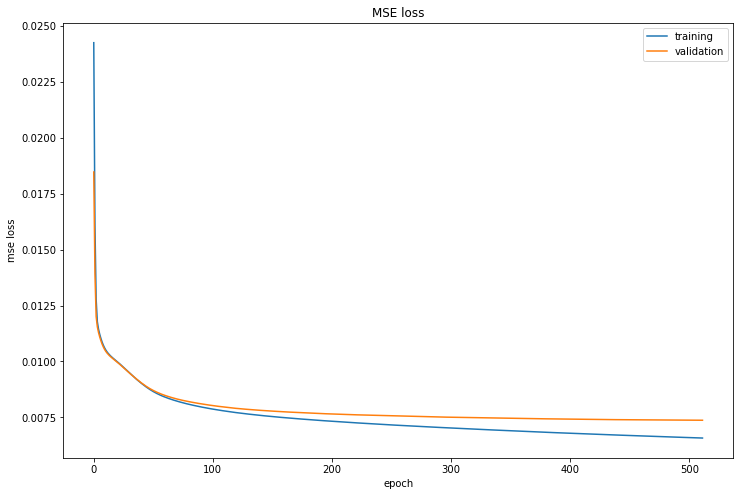

In [8]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [9]:
class Analysis:
    def __init__(self):
        self.crop = 100
        self.fsize = 6
        self.histogram_bins = 40
        
    def wrap_phi(self, var):
        var = var%(2*np.pi)
        var = var - 2*np.pi*(var > np.pi)
        return var
        
    def predictions_vs_sample(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2, self.fsize*len(names)))
        for i in range(0, len(names)):
            compare_small = compare[:self.crop,i]
            true_small = true[:self.crop,i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            plt.subplot(len(names), 1, i+1)
            plt.plot(range(0,self.crop), compare_small, 'bo', markersize=3, label = 'Predictions')
            plt.plot(range(0,self.crop), true_small, 'ro', markersize=3, label = 'True Value')
            ym, yM = plt.ylim()
            for x in range(self.crop):
                plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                            min(compare_small[x], true_small[x]), 
                            ymax= max(compare_small[x], true_small[x]))
            plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=self.crop+20, alpha=0.5)
            MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
            plt.xlabel('Sample')
            plt.xlim(0, self.crop)
            plt.ylabel(names[i])
            plt.title(names[i] + " MSE: " + str(MSE))
            plt.legend()
    
    def display_errors(self, compare, true, names, wrap_phi):
        MSE = 1/compare.size*np.sum((compare- true)**2)
        print("total MSE: " + str(MSE))
        print(" ")
        for i in range(len(names)):
            diff = compare[:,i] -true[:,i]
            if wrap_phi and "phi" in names[i]:
                diff = self.wrap_phi(diff)
            MSE = 1/compare[:,i].size*np.sum((diff)**2)
            print("{0} MSE : ".format(names[i]), '%.10f'%MSE)
    
    def difference_histogram(self, compare, true, names, wrap_phi, bins):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            diff = true[:,i] - compare[:,i]
            hist0, bin_edges = np.histogram(true[:, i], bins=40)
            if bins[i] is None:
                hbins = bin_edges
            else:
                hbins = bins[i]
            plt.hist(diff, hbins, histtype='step', color='purple', label='true - predicted', density=True)
            plt.xlabel("Difference (Mean: {0}, Std: {1})".format(np.mean(diff), np.std(diff)))
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
            
    def variable_histogram(self, compare, true, names, wrap_phi, bins): 
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            compare_small = compare[:, i]
            true_small = true[:, i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            hist0, bin_edges = np.histogram(true[:, i], bins=40)
            
            if bins[i] is None:
                hbins = bin_edges
            else:
                hbins = bins[i]
                
            plt.hist(true_small, hbins, histtype='step', color='b', label='true values', density=False)
            plt.hist(compare_small, hbins, histtype='step', color='r', label='predictions', density=False)
            plt.xlabel(names[i])
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
    
    def difference_vs_variable(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], true[:, i]-compare[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
            plt.xlabel('True ' + names[i])
            plt.legend()
            plt.ylabel('Difference')
    
    def predicted_vs_true(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], compare[:, i], 'o', color='g', markersize=2)
            line = np.linspace(np.min(true[:, i]), np.max(true[:, i]), 100)
            plt.plot(line, line, color='b')
            plt.xlabel('True')
            plt.title(names[i])
            plt.ylabel('Predicted')

In [10]:
display = Analysis()

predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

# Training scale plots 

In [11]:
display.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.007365897854866887
 
th_px MSE :  0.0059134128
th_py MSE :  0.0082405660
th_eta MSE :  0.0105261467
tl_px MSE :  0.0046221579
tl_py MSE :  0.0105713167
tl_eta MSE :  0.0087960713
wl_px MSE :  0.0017512126
wl_py MSE :  0.0073416948
wl_eta MSE :  0.0085305019


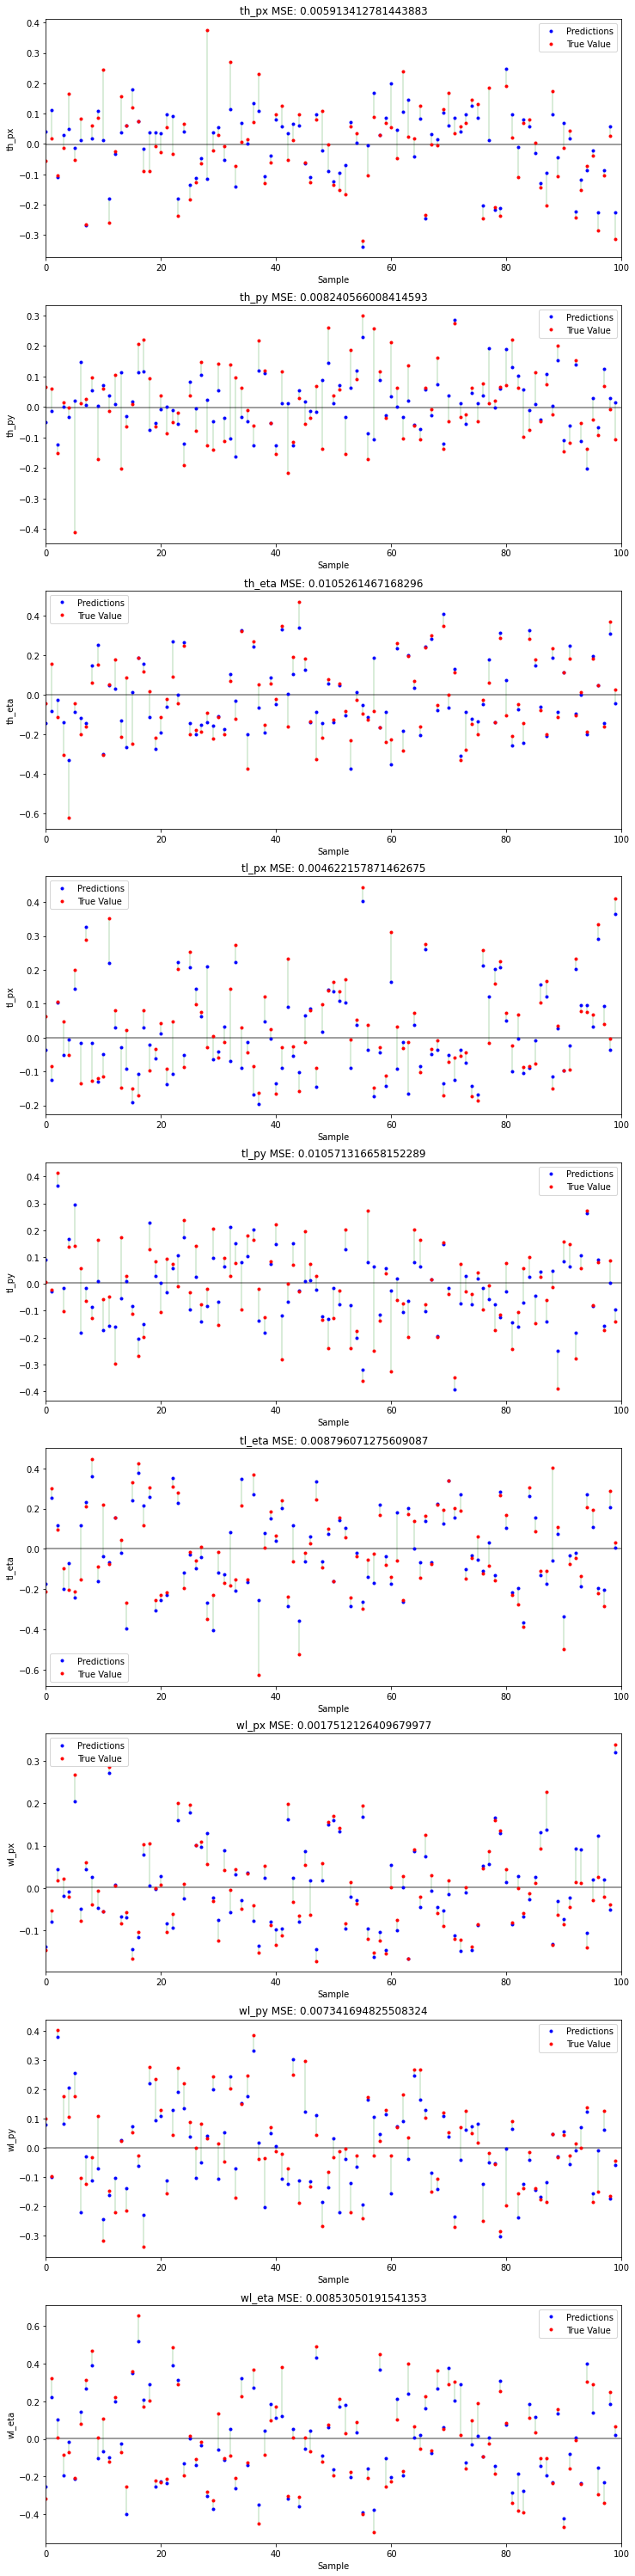

In [12]:
display.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

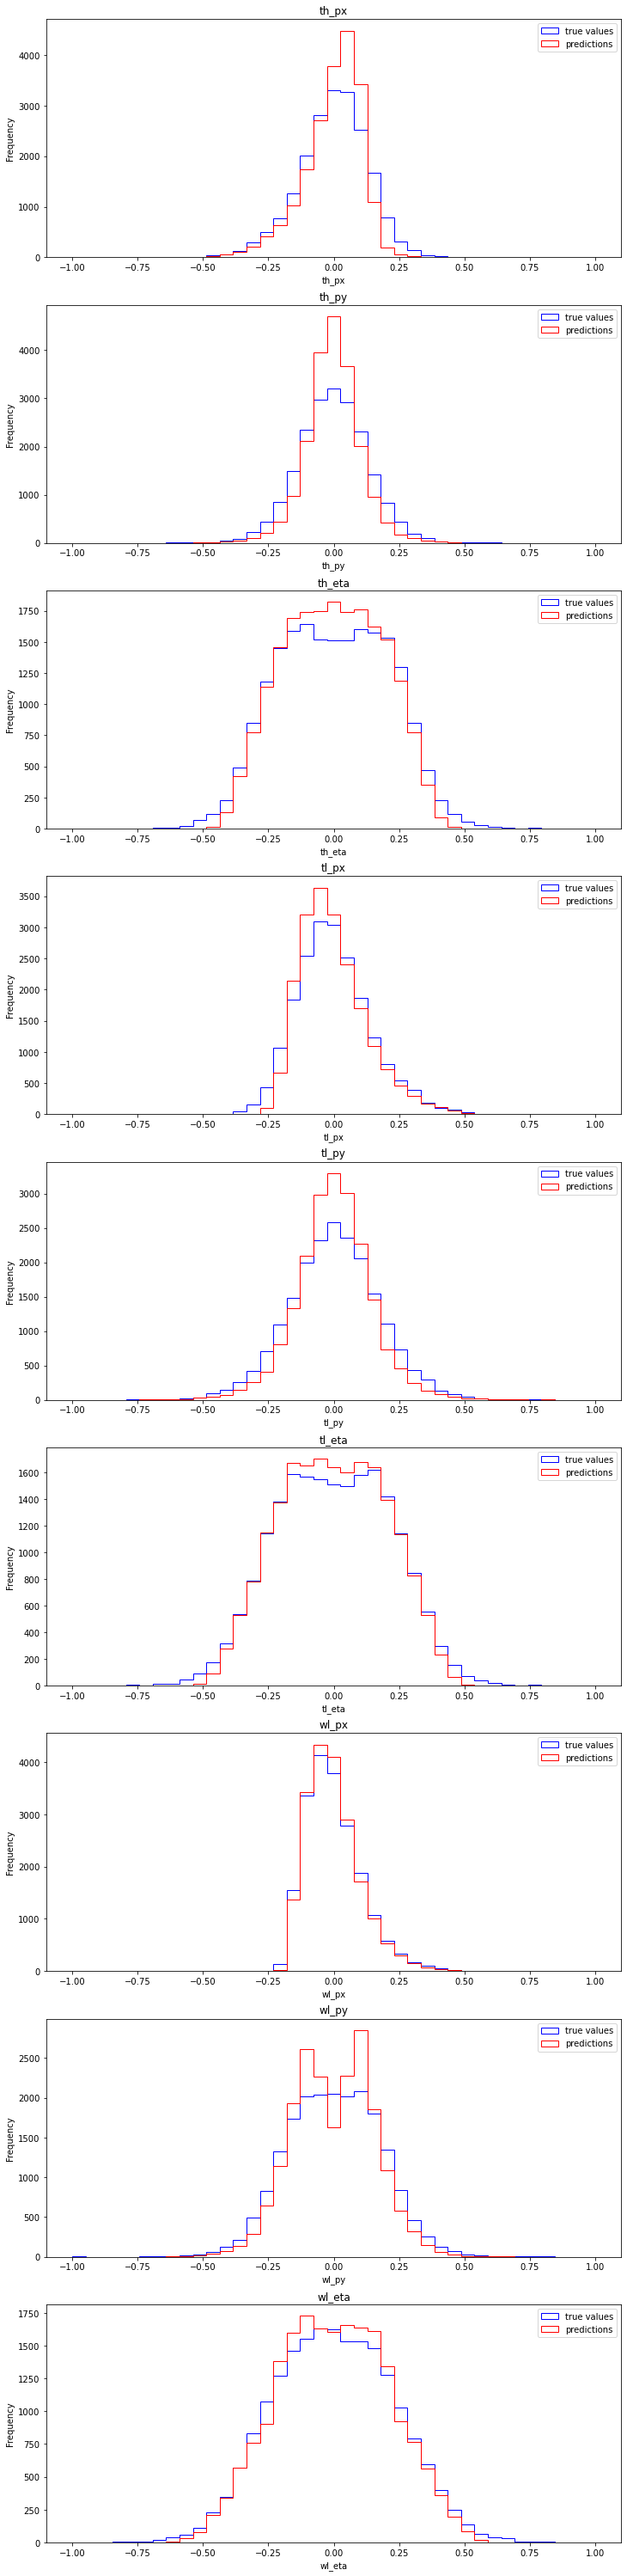

In [13]:
display.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

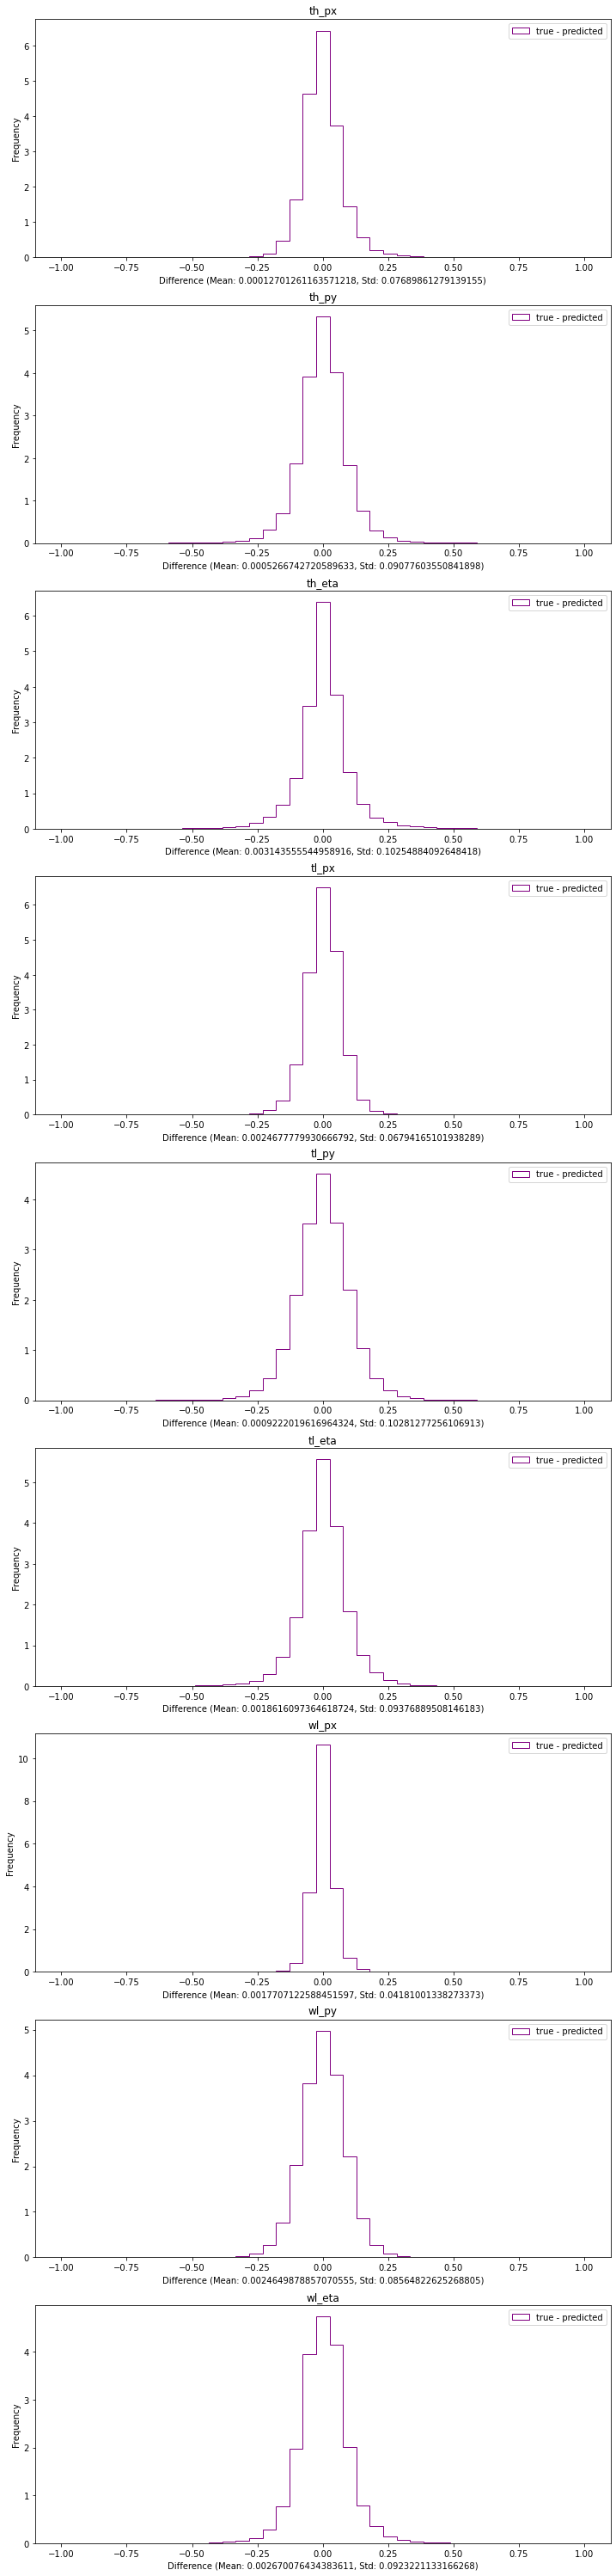

In [14]:
display.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

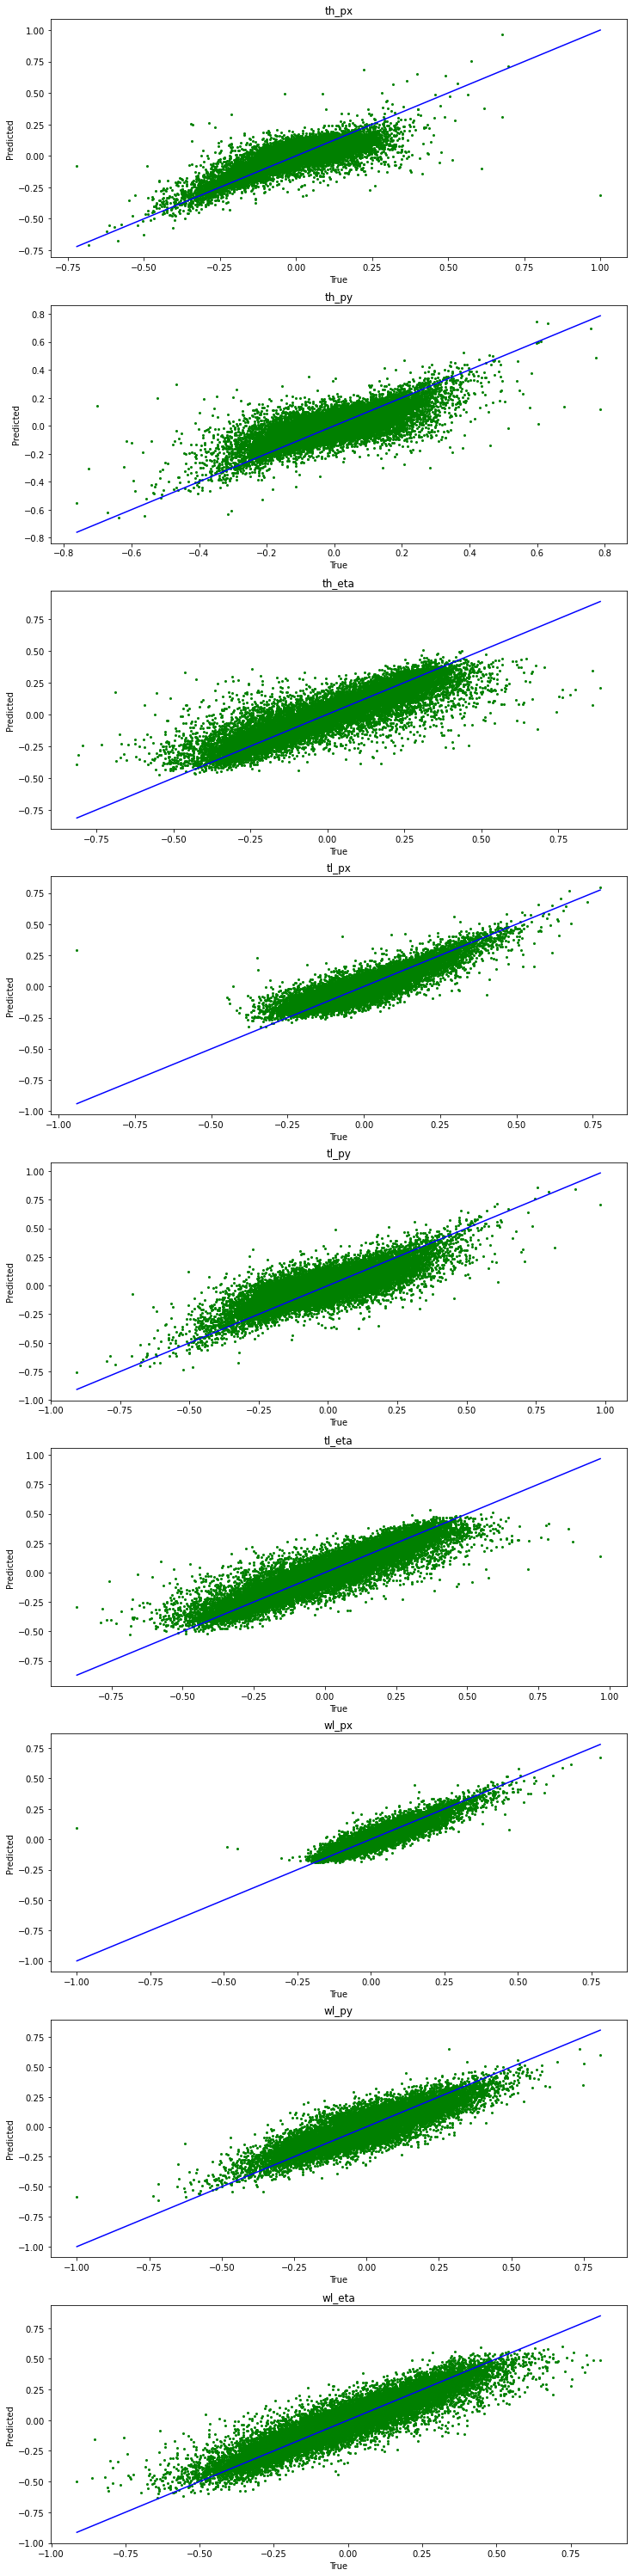

In [15]:
display.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [16]:
display.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 589.2196893264838
 
th_pt MSE :  2830.4161610020
th_eta MSE :  0.5790419402
th_phi MSE :  0.8977147909
tl_pt MSE :  1825.1584454689
tl_eta MSE :  0.4401653583
tl_phi MSE :  0.5695057239
wl_pt MSE :  639.3590351898
wl_eta MSE :  0.3048537918
wl_phi MSE :  0.2001714240


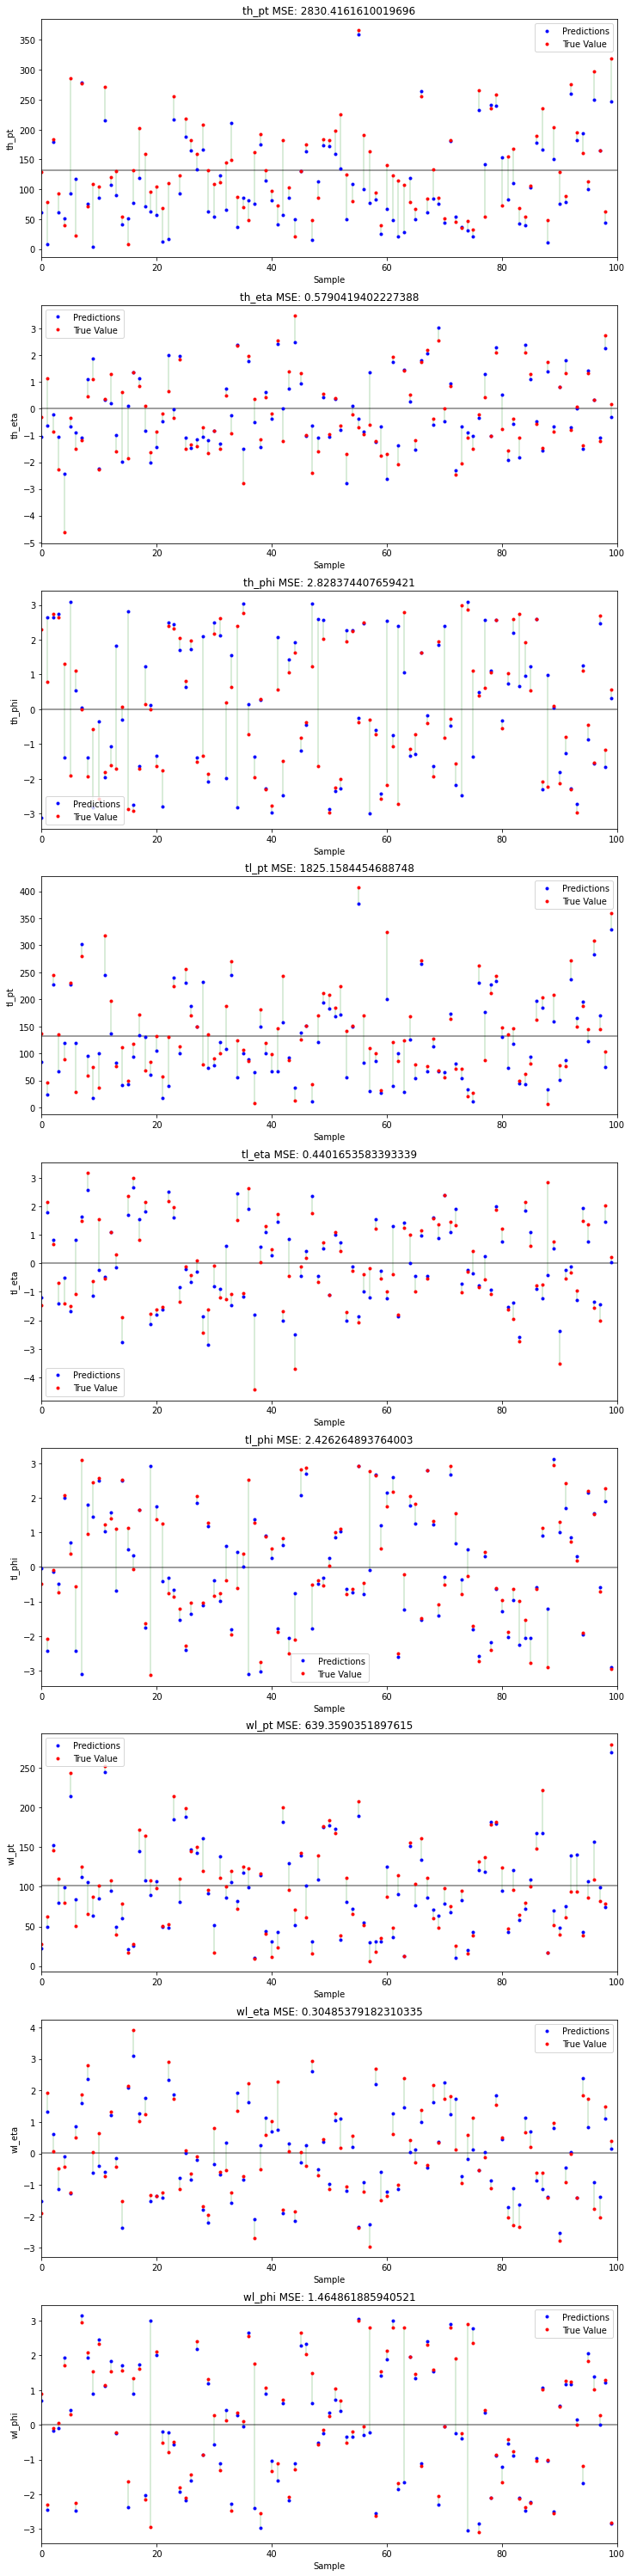

In [17]:
display.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

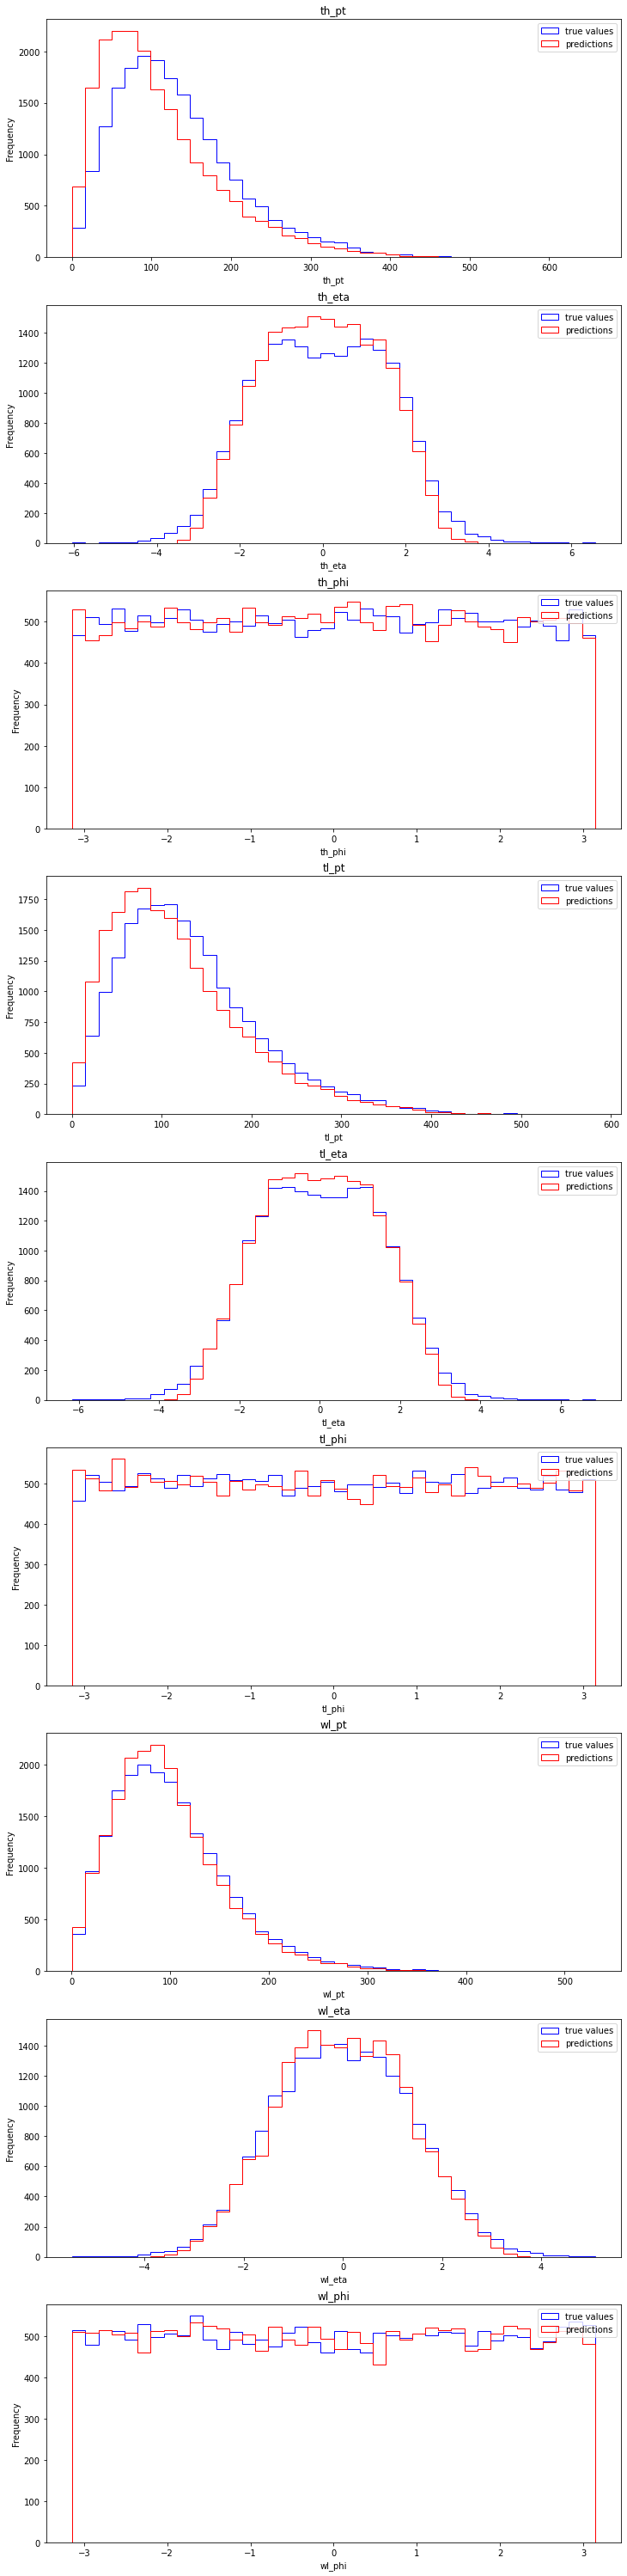

In [18]:
display.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

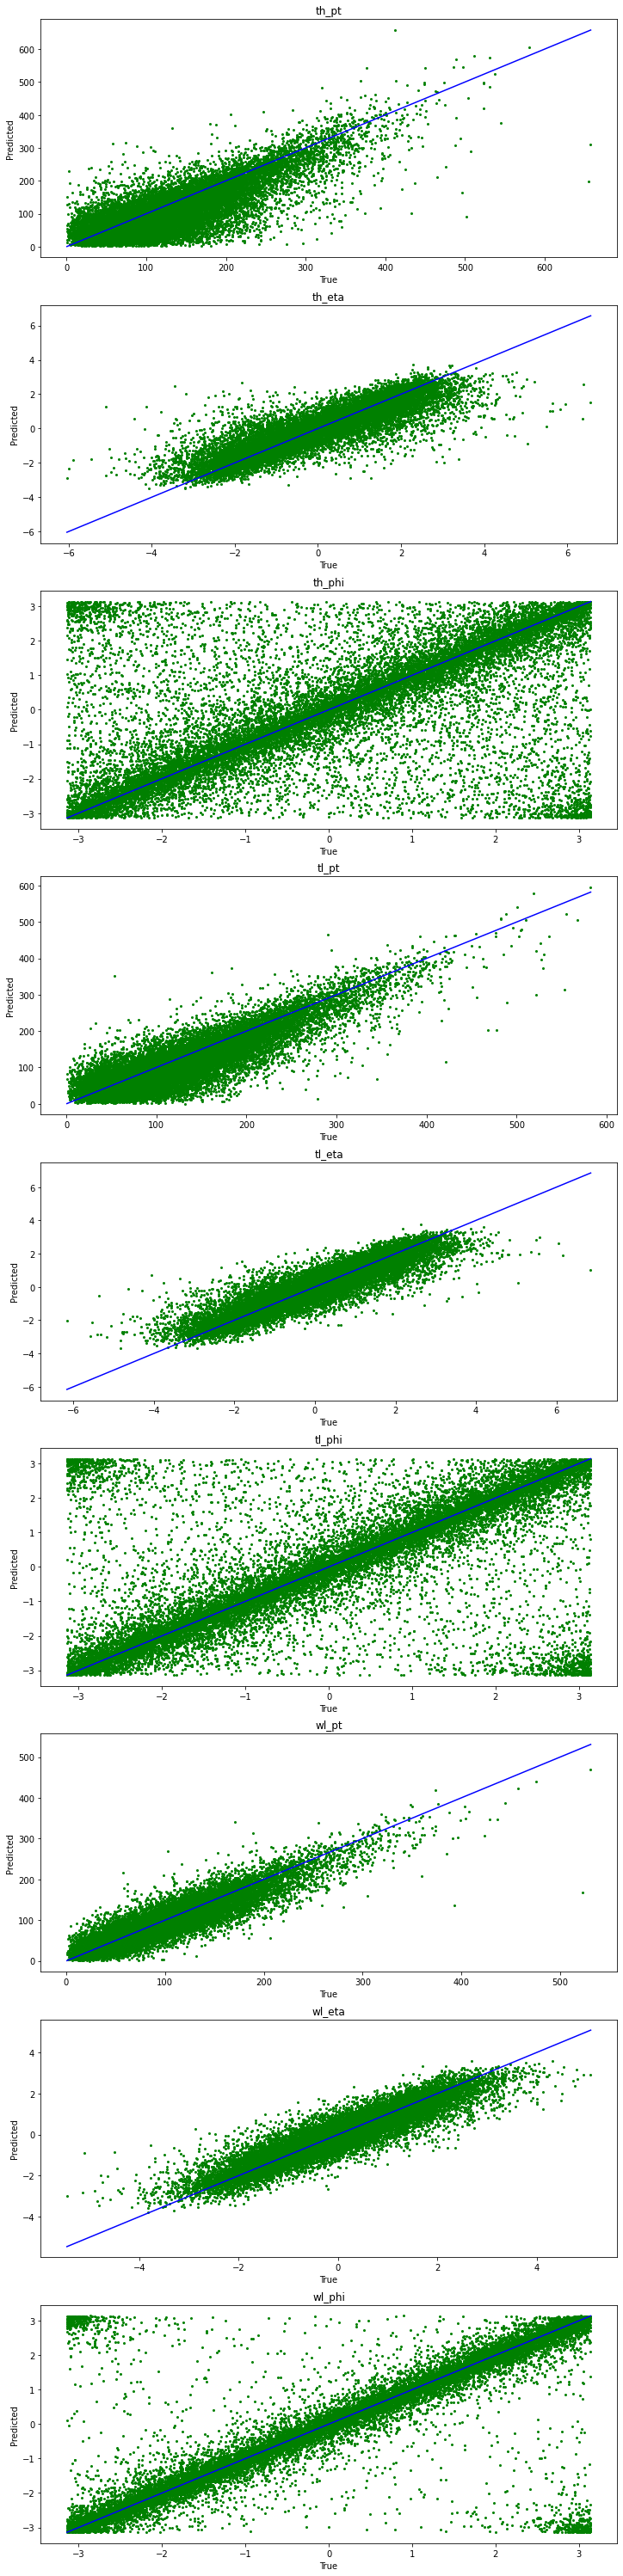

In [19]:
display.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)